In [1]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 42.5 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 3.5 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.5-cp310-cp310-linux_x86_64.whl size=293379 sha256=ef58018573494924a4aee901ffdf6c547e41881c1972810e1b420b21e8ee538c
  Stored in directory: /root/.cache/pip/wheels/06/80/9b/98db0d58349a2f5c09f8406789ade4270762f97b7d26f2fa22
Successfully built peewee


In [2]:
import yfinance as yf
from datetime import datetime
import torch
torch.manual_seed(42)

In [3]:
ticker_symbol = 'AAPL'
ticker_data = yf.Ticker(ticker_symbol)
apple_data = ticker_data.history(start='2014-01-01', end=datetime.now())
apple_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-01-02 00:00:00-05:00,17.352860,17.395018,17.238565,17.273228,234684800,0.0,0.0
2014-01-03 00:00:00-05:00,17.264801,17.291032,16.876634,16.893810,392467600,0.0,0.0
2014-01-06 00:00:00-05:00,16.783577,17.075559,16.663348,16.985935,412610800,0.0,0.0
2014-01-07 00:00:00-05:00,16.998112,17.049326,16.798253,16.864456,317209200,0.0,0.0
2014-01-08 00:00:00-05:00,16.826038,17.036829,16.822293,16.971251,258529600,0.0,0.0
...,...,...,...,...,...,...,...
2024-06-28 00:00:00-04:00,215.770004,216.070007,210.300003,210.619995,82542700,0.0,0.0
2024-07-01 00:00:00-04:00,212.089996,217.509995,211.919998,216.750000,60402900,0.0,0.0
2024-07-02 00:00:00-04:00,216.149994,220.380005,215.100006,220.270004,58046200,0.0,0.0


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

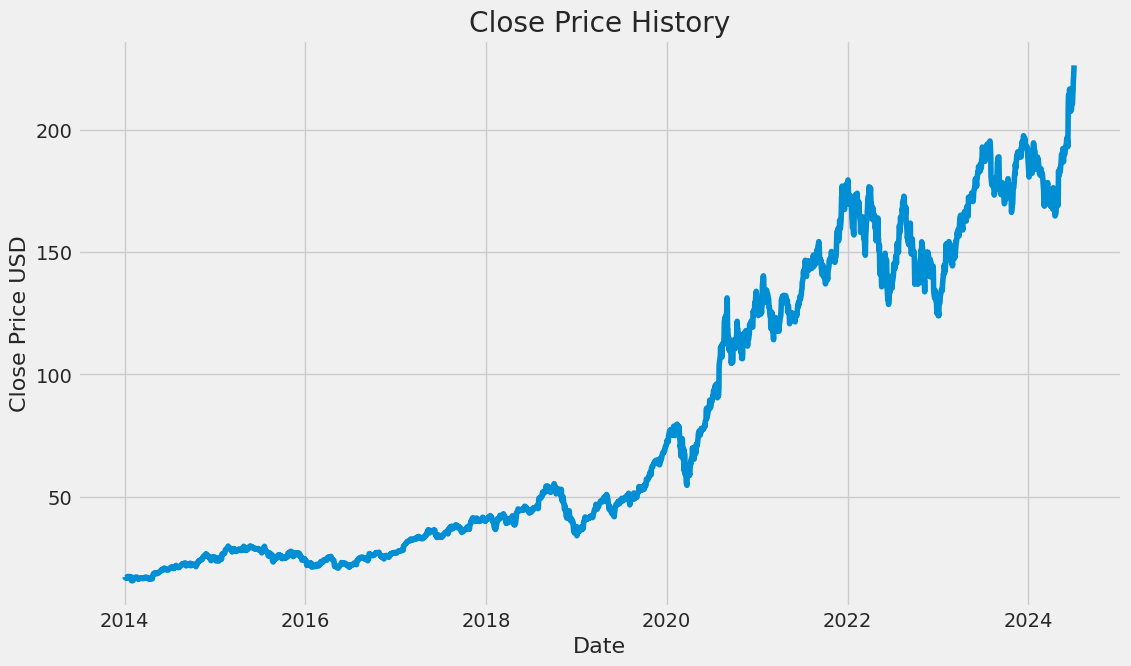

In [5]:
plt.figure(figsize=(12,7))
plt.title("Close Price History")
plt.plot(apple_data['Close'])
plt.xlabel("Date", fontsize=16)
plt.ylabel("Close Price USD", fontsize=16)
plt.show()

In [6]:
import numpy as np
data = apple_data.filter(["Close"])
dataset = data.values
#train split
training_data_len = int(np.ceil(len(dataset)* .95))
training_data_len

2512

In [7]:
import torch 
dataset = torch.tensor(dataset)
dataset

tensor([[ 17.2732],
        [ 16.8938],
        [ 16.9859],
        ...,
        [220.2700],
        [221.5500],
        [226.3400]], dtype=torch.float64)

In [8]:
def min_max_scalar(tensor):
    max_val, _ = torch.max(tensor, dim=0)
    min_val, _ = torch.min(tensor, dim=0)
    range_val = max_val - min_val
    range_val[range_val == 0] = 1
    
    scaled_tensor = (tensor - min_val) / range_val
    return scaled_tensor, max_val, min_val
scaled_data, max_val, min_val = min_max_scalar(dataset)
max_val

tensor([226.3400], dtype=torch.float64)

In [9]:
train_data = scaled_data[0:training_data_len, :]
train_data

tensor([[0.0079],
        [0.0061],
        [0.0065],
        ...,
        [0.8480],
        [0.8473],
        [0.8422]], dtype=torch.float64)

In [10]:
def create_sequences(data, sequence_length):
    xs, ys =[],[]
    for i in range (len(data) - sequence_length-1):
        x = data[i:i+sequence_length]
        y = data[sequence_length + i]
        xs.append(torch.tensor(x))
        ys.append(torch.tensor(y))
    return torch.stack(xs), torch.stack(ys)

sequence_length = 60 
x_train, y_train = create_sequences(train_data, sequence_length)

/tmp/ipykernel_18/426960757.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xs.append(torch.tensor(x))
/tmp/ipykernel_18/426960757.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ys.append(torch.tensor(y))


In [11]:
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(x_train,y_train)

batch_size = 32
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
data_loader

In [12]:
import torch.nn as nn
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size=1, hidden_size=128, dropout=0.2, batch_first=True)
        self.lstm2 = nn.LSTM(128, 64, batch_first=True)
        self.dense1 = nn.Linear(64,25)
        self.dense2 = nn.Linear(25,1)
    
    def forward(self, x):
        x,_ = self.lstm1(x)
        x,_ = self.lstm2(x)
        x = x[:,-1,:]
        x = self.dense1(x)
        x = self.dense2(x)
        return x

In [13]:
model = LSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [14]:
x_train = x_train.float()
y_train = y_train.float()
x_train

tensor([[[0.0079],
         [0.0061],
         [0.0065],
         ...,
         [0.0064],
         [0.0061],
         [0.0060]],

        [[0.0061],
         [0.0065],
         [0.0060],
         ...,
         [0.0061],
         [0.0060],
         [0.0060]],

        [[0.0065],
         [0.0060],
         [0.0065],
         ...,
         [0.0060],
         [0.0060],
         [0.0067]],

        ...,

        [[0.7582],
         [0.7387],
         [0.7315],
         ...,
         [0.8636],
         [0.8610],
         [0.8531]],

        [[0.7387],
         [0.7315],
         [0.7327],
         ...,
         [0.8610],
         [0.8531],
         [0.8580]],

        [[0.7315],
         [0.7327],
         [0.7352],
         ...,
         [0.8531],
         [0.8580],
         [0.8480]]])

In [15]:
epochs = 1

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for x_batch, y_batch in data_loader:
        x_batch = x_batch.float()
        y_batch = y_batch.float()  
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch [{epoch+1}/{epochs}], Average Loss: {total_loss / len(data_loader):.4f}')

Epoch [1/1], Average Loss: 0.0491


In [16]:
test_data = scaled_data[training_data_len - sequence_length  :, :]
len(test_data)

192

In [17]:
x_test, y_test = create_sequences(test_data, sequence_length)

x_test = x_test.float()
y_test = y_test.float()

/tmp/ipykernel_18/426960757.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xs.append(torch.tensor(x))
/tmp/ipykernel_18/426960757.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ys.append(torch.tensor(y))


In [18]:
len(x_test)

131

In [19]:
model.eval()

with torch.no_grad():
    predictions = model(x_test)

In [20]:
def inverse_min_max_scaler(scaled_tensor, min_val, max_val):
    original_tensor = scaled_tensor * (max_val - min_val) + min_val
    return original_tensor

In [21]:
predictions = inverse_min_max_scaler(predictions, min_val, max_val)
predictions

tensor([[203.3474],
        [203.3408],
        [203.2795],
        [203.2068],
        [203.0782],
        [202.5994],
        [201.8919],
        [200.9642],
        [199.9119],
        [199.0375],
        [198.2670],
        [197.6474],
        [197.1144],
        [196.6771],
        [196.2050],
        [195.6956],
        [195.4769],
        [195.5606],
        [195.9288],
        [196.5101],
        [197.1602],
        [197.8121],
        [198.3541],
        [198.7794],
        [198.9398],
        [198.7720],
        [198.5424],
        [198.2216],
        [197.9509],
        [197.7919],
        [197.7074],
        [197.6207],
        [197.5794],
        [197.4820],
        [197.2601],
        [196.9368],
        [196.5532],
        [196.0732],
        [195.5238],
        [194.9940],
        [194.5941],
        [194.1919],
        [193.7483],
        [193.3755],
        [192.9954],
        [192.5993],
        [192.1591],
        [191.4896],
        [190.4788],
        [189.2663],


In [22]:
max_val

tensor([226.3400], dtype=torch.float64)

/tmp/ipykernel_18/3515668171.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


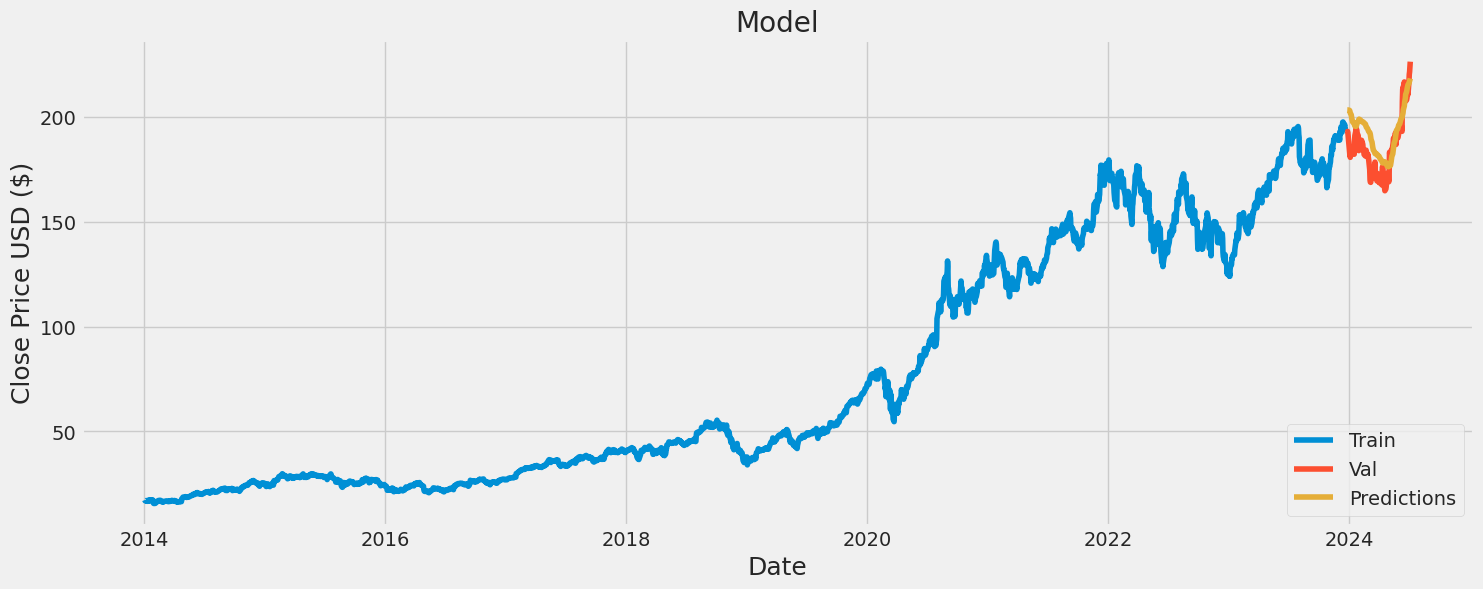

In [23]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len + 1:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()